In [136]:
# PORTFOLIO OPTIMIZATION

# O modelo busca otimizar a alocação de índices do mercado americano, para isso a Rede Neural usa como 
# input o retorno diário desses índices, que foram capturados da api do Yahoo Finance
# Durante o treinamento a rede busca maximizar o sharpe ratio, para isso foi criado uma loss function que retorna
# o - sharpe.

# S = (Ri – Rf) / (σi)

# S: Índice de Sharpe;
# Ri: retorno do ativo analisado;
# Rf: retorno livre de risco
# σi: risco do ativo.

# Para o treinamento da rede foi utilizado dados de retorno de 2014 a 2018
# Para medida de avaliação do modelo, foi comparado com os retornos de uma alocação Mean Variance, usando 
# a biblioteca pypfopt do python

In [ ]:
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from keras.models import load_model,save_model

In [3]:
def get_data(start_date='2014-01-01', end_date='2018-01-01'):

    tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
    
    
    df_list = pd.DataFrame()
    for ticker in tickers:
        data = yf.download(ticker, group_by="Ticker", start=start_date, end=end_date)
        data['ticker'] = ticker
        data = data[['Close','ticker']]
        df_list = pd.concat([df_list,data])
        
    df_pivot = pd.pivot_table(df_list, values='Close',index=df_list.index.values,
                        columns=['ticker'])
    return df_pivot

In [4]:
data = get_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [128]:
data.head()

ticker,AGG,DBC,VIXY,VTI
2014-01-02,106.500000,25.290001,2328.800049,95.080002
2014-01-03,106.540001,25.129999,2313.600098,95.059998
2014-01-06,106.680000,25.160000,2284.800049,94.809998
2014-01-07,106.730003,25.139999,2234.399902,95.419998
2014-01-08,106.410004,24.900000,2238.399902,95.489998


In [9]:
def get_return_data(data):
    assets = data.columns
    portfolio_return_data = np.concatenate([data.pct_change().values[1:] ], axis=1)
    portfolio_return_data_df = pd.DataFrame(portfolio_return_data,  columns =assets,index=data.index.values[1:],)  
    return portfolio_return_data_df


In [11]:
return_data = get_return_data(data)
return_data.head()

ticker,AGG,DBC,VIXY,VTI
2014-01-03,0.000376,-0.006327,-0.006527,-0.000210
2014-01-06,0.001314,0.001194,-0.012448,-0.002630
2014-01-07,0.000469,-0.000795,-0.022059,0.006434
2014-01-08,-0.002998,-0.009547,0.001790,0.000734
2014-01-09,0.001410,-0.008032,0.001787,0.000838


In [107]:
    
class Model:
    def __init__(self,timesteps_input=64,timesteps_output=19):
        self.data = None
        self.model = None
        
        self.timesteps_input = timesteps_input
        self.timesteps_output = timesteps_output
        
        
    def build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, 
        outputs - the number of assets
        
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            data = tf.divide(self.data, self.data[0])  

            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1] 

            sharpe = (K.mean(portfolio_returns) * 255) / (K.std(portfolio_returns)* np.sqrt(255))
            
            return -sharpe
    

        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self,data):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        tickers = data.columns
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.build_model((None,8), len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=50)

In [138]:
model = Model()
train_data = get_data()
model_trained = model.train(train_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.8622
Epoch 2/50
1/1 [==============================] - 0s 239ms/step - loss: 0.8191
Epoch 3/50
1/1 [==============================] - 0s 231ms/step - loss: 0.7610
Epoch 4/50
1/1 [==============================] - 0s 241ms/step - loss: 0.6832
Epoch 5/50
1/1 [==============================] - 0s 231ms/step - loss: 0.5904
Epoch 6/50
1/1 [==============================] - 0s 228ms/step - loss: 0.4896
Epoch 7/50
1/1 [==============================] - 0s 210ms/step - loss: 0.3755
Epoch 8/50
1/1 [==============================] - 0s 231ms/step - loss: 0.2441
Epoch 9/50
1/1 [==============================] - 0s 220ms/step - loss: 0.0984
Epoch 10/50
1/1 

In [125]:
def get_allocations(model,data,allocation_date=None):
    
    data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
    fit_predict_data = data_w_ret[np.newaxis,:]        
    tickers = data.columns
    df = pd.DataFrame(model.predict(fit_predict_data)[0])
    list_allocations = {}
    for i in range(0,len(tickers)):
        list_allocations[tickers[i]] = df[0][i]
    
    return list_allocations

In [98]:
def portfolio_return(portfolio_prices_data,trained_model):

    portfolio_prices_data = portfolio_prices_data
#    portfolio_prices_data.index = portfolio_prices_data.index.strftime('%Y-%m-%d')

    trained_model = trained_model
    
    allocations = get_allocations(trained_model,portfolio_prices_data)
    assets = portfolio_prices_data.columns
    portfolio_return_data = np.concatenate([portfolio_prices_data.pct_change().values[1:] ], axis=1)
    portfolio_return_data_df = pd.DataFrame(portfolio_return_data,  columns =assets,index=portfolio_prices_data.index.values[1:])  
#    allocations_df = pd.DataFrame(allocations, index=[0])
    portfolio_daily_return_data_df = pd.DataFrame()
    for asset in assets:
        portfolio_daily_return_data_df[asset + ' return'] = portfolio_return_data_df[asset]*allocations[asset]
    portfolio_daily_return_data_df['daily_return'] = portfolio_daily_return_data_df.sum(axis = 1)
    portfolio_daily_return_data_df['cumulative_ret'] = (portfolio_daily_return_data_df['daily_return'] + 1).cumprod()
    return portfolio_daily_return_data_df

In [105]:

start_date = '2018-01-01'
end_date = '2019-10-01'
test_data = get_data(start_date,end_date)
trained_model = load_model('my_model.h5',compile=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [104]:
allocations = get_allocations(trained_model,test_data)
allocations_df = pd.DataFrame(allocations, index=[0])
allocations_df.head()

,AGG,DBC,VIXY,VTI
0,0.254807,0.004283,0.00962,0.73129


In [102]:
port_return = portfolio_return(test_data,trained_model)
port_return = port_return.sort_index(ascending=False)

In [103]:
port_return

,AGG return,DBC return,VIXY return,VTI return,daily_return,cumulative_ret
2019-09-30,0.000068,-0.000042,-0.000273,0.003406,0.003158,1.085543
2019-09-27,0.000316,-0.000017,0.000266,-0.004353,-0.003788,1.082126
2019-09-26,0.000429,0.000000,0.000064,-0.002218,-0.001725,1.086241
2019-09-25,-0.001057,-0.000025,-0.000208,0.004610,0.003319,1.088117
2019-09-24,0.000699,-0.000050,0.000446,-0.006778,-0.005682,1.084518
...,...,...,...,...,...,...
2018-01-09,-0.000701,0.000028,0.000098,0.001351,0.000777,1.013115
2018-01-08,-0.000070,-0.000003,-0.000123,0.001667,0.001471,1.012329
2018-01-05,-0.000163,-0.000015,0.000004,0.004297,0.004123,1.010842
2018-01-04,-0.000163,-0.000005,-0.000031,0.002788,0.002589,1.006691


In [193]:
sharpe_annual = 252**0.5*(port_return['daily_return'].mean())/ port_return['daily_return'].std()
sharpe_annual

0.4944439699748607

In [201]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

def mv_portfolio(portfolio_prices_data):
    mu = mean_historical_return(portfolio_prices_data)
    S = CovarianceShrinkage(portfolio_prices_data).ledoit_wolf()
    
    
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    #print(cleaned_weights)
    ef.portfolio_performance(verbose=True)
    assets = portfolio_prices_data.columns.to_list()
    teste = portfolio_prices_data.pct_change()[1:]
    teste_annual = teste.mean()
    teste_annual_pivot = pd.DataFrame(teste_annual)
    teste_annual_pivot = teste_annual_pivot.pivot_table(columns=teste_annual_pivot.index.values)
    for asset in assets:
        teste_annual_pivot[asset] = teste_annual_pivot[asset] * cleaned_weights[asset]
    teste_annual_pivot['anual'] = teste_annual_pivot.sum(axis = 1)
    teste_data_with_return_mv = portfolio_prices_data.pct_change()[1:]
    
    for asset in assets:
        teste_data_with_return_mv[asset] = teste_data_with_return_mv[asset] * cleaned_weights[asset]
        
    teste_data_with_return_mv['daily_return'] = teste_data_with_return_mv.sum(axis = 1)
    teste_data_with_return_mv['cumulative_ret'] = (teste_data_with_return_mv['daily_return'] + 1).cumprod()
    return teste_data_with_return_mv


In [202]:
mv = mv_portfolio(test_data)
mv = mv.sort_index(ascending=False)
mv.head()

Expected annual return: 4.2%
Annual volatility: 11.6%
Sharpe Ratio: 0.19


ticker,AGG,DBC,VIXY,VTI,daily_return,cumulative_ret
2019-09-30,0.000053,-0.0,-0.000781,0.003597,0.002869,1.095348
2019-09-27,0.000248,-0.0,0.000760,-0.004597,-0.003588,1.092214
2019-09-26,0.000337,0.0,0.000184,-0.002342,-0.001821,1.096148
2019-09-25,-0.000831,-0.0,-0.000596,0.004868,0.003441,1.098147
2019-09-24,0.000549,-0.0,0.001277,-0.007158,-0.005332,1.094382


<Figure size 432x288 with 0 Axes>

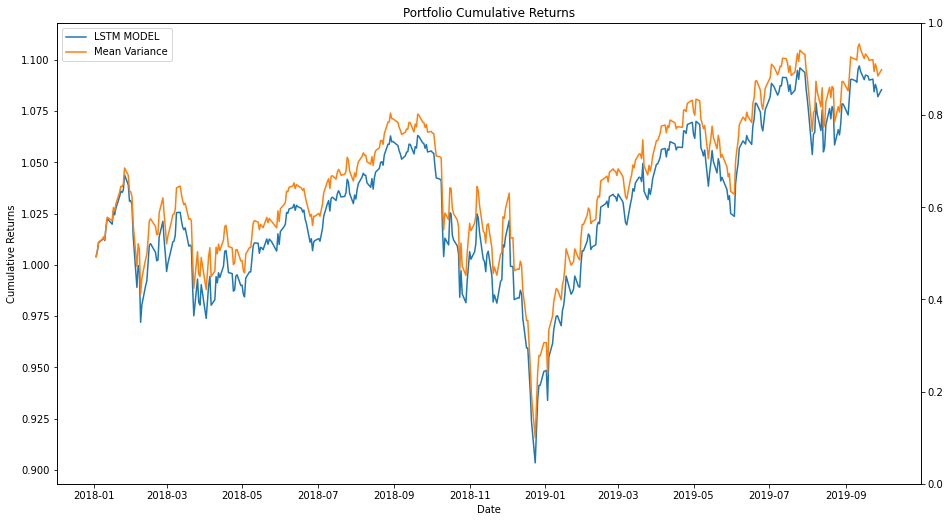

In [122]:
%matplotlib inline

fig = plt.figure()
fig=plt.figure(figsize=(15, 8))

ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(port_return['cumulative_ret'],label="LSTM MODEL" )
#
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Portfolio Cumulative Returns")
#
ax2 = ax1.twinx()
ax1.plot(mv['cumulative_ret'] ,label="Mean Variance" )
leg = ax1.legend();

#
plt.show();
#